### IMPORT SECTION

In [1]:
# Anıl Öztürk
# 504181504
#########################

import numpy as np
import matplotlib.pyplot as plt

from networkx import nx, gnm_random_graph, gnp_random_graph, erdos_renyi_graph
import networkx.algorithms.community as nx_comm
from networkx.algorithms.smallworld import random_reference

import random
import community # can be installed with: "pip install python-louvain"
from numpy import linalg as LA
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

### HYPERPARAMETER SECTION
I changed the number of graphs to 100 instead of 20 in order to have a more robust statistics. In order to make the process shorter, I reduced the number of edges and made it to 45 instead of 200. Since decreasing the number of edges will reduce the probability of being complete, I also set the Erdös probability coefficient to be a relatively high value. From this section, you can set the parameters as the homework wants.

In [2]:
V = 50  # node count
min_p = 0.08 # Specific minimum p value for Erdos-Renyi model
max_p = 0.85 # Specific maximum p value for Erdos-Renyi model

# Erdos-Renyi is a generative model. Maslov-Sneppen algorithm will create rewired variants of the graphs.
graph_count = 100 # to be used for erdös and maslov graphs, seperately
node_draw_size = 75 # Node circle size in plots

seed = 1773 # Seed for all stochastic actions - ITU will bring us luck

## DO NOT CHANGE
np.random.seed(seed)
graph_creation_seed = np.random.randint(seed, size = graph_count*150000) ## for graph_count*150000 creations just in case of creating not connected graphs
graph_creation_seed = [int(i) for i in graph_creation_seed]
max_solver_iterations = 1000000000

### For eye-health 🤡

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}  
</style>
""")

import warnings
warnings.filterwarnings("ignore")

# START POINT OF THE HOMEWORK

### Creating the Erdos-Renyi graphs and Maslov-Sneppen variants

This may take a while since it tries to get "connected" graphs. I used the Erdös-Renyi generator while creating the graphs with Maslov. Because it is one of the methods of creating random graphs. I think other rule-based generators cannot generate graphs similar to the real world structures.

In [4]:
## Setting different Erdös-Renyi probabilities to prevent very similar node-degreed graphs
probs = np.linspace(min_p, max_p, num=graph_count)

# Creating a graph array to easily iterate over them
erdos_array = []

seed_i = 0
i = 0

print("Creating Erdös-Renyi graphs..")

while i < graph_count:
    
    temp_graph = erdos_renyi_graph(V, probs[i], seed = graph_creation_seed[seed_i], directed = False)
    
    # The authors said that they guaranteed creating connected graphs during this process
    if nx.is_connected(temp_graph): 
        erdos_array.append(temp_graph.copy())
    else:
        i -= 1 ## try creating again
        
    seed_i += 1 ## changing the seed to create different graph
    i += 1

# Creating Maslov-Sneppen graphs
print("Creating Maslov-Sneppen graphs..")
time.sleep(1)

i = 0
maslov_array = []

while i < graph_count:
    
    temp_graph = erdos_renyi_graph(V, probs[i], seed = graph_creation_seed[seed_i], directed = False)
    
    # The authors said that they guaranteed creating connected graphs during this process
    if nx.is_connected(temp_graph): 
        maslov_array.append(temp_graph.copy())
    else:
        i -= 1 ## try creating again
        
    seed_i += 1 ## changing the seed to create different graph
    i += 1
    
maslov_array = [random_reference(G.copy(), seed = graph_creation_seed[seed_i]) for i,G in enumerate(tqdm(maslov_array))]

# Giving random weights to the Erdös-Renyi graphs' links
for G in erdos_array:
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = random.randint(1, 10)
        
# Giving fixed weights (1) to the Maslov-Sneppen graphs' links (still can be considered as unweighted)
for G in maslov_array:
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = 1
        
#print(graph_creation_seed)

Creating Erdös-Renyi graphs..
Creating Maslov-Sneppen graphs..


100%|██████████| 100/100 [04:28<00:00,  2.68s/it]


# Part A: Simulating random weighted and unweighted networks

### 1. Briefly explain how Erdos-Renyi generative model works 
With given node count $n$ and probability $0 \leq p \leq 1$, the Erdos-Renyi model creates an undirected graph. The graph has edges between all pairs of its nodes with probability $p$ for each edge.

### 2. What are the key properties of Erdos-Renyi graphs?
The probability $p$ can be expressed in terms of the average value of the average number of links; $p=(E/V) / (V−1)\\ $
Graphs with the same number of links are equally probable

### 3. Briefly explain how Maslov-Sneppen algorithm works
The algorithm rewires (changes the locations of the edges) all the nodes in the graph while preserving the number of nodes and edges, in addition to the degree sequence and approximate node strength (weighted degree) distributions.

### 4. What are the key properties of Maslov-Sneppen graphs?
All the node degrees are being preserved$\\ $
It can be used to identify the graph's important non-random topological patterns
### 5. Visualize two random graphs you simulated (ER and MS)

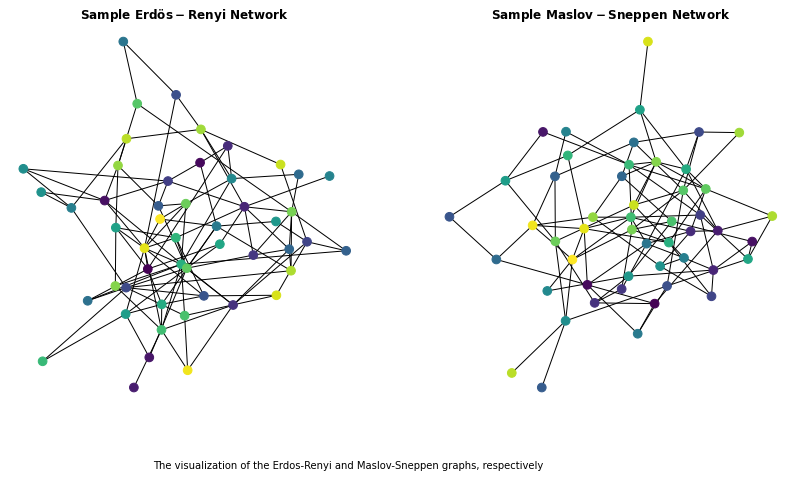

In [5]:
# Fixing the node positions for more reasonable display (both erdos and maslov variants have their nodes at the same positions)
#node_positions = nx.spring_layout(erdos_array[0], seed = seed)

sampled_networks = [erdos_array[0], maslov_array[0]] # Selecting the first pair of Erdos and Maslov versions

# Creating the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = axes.flatten()
ax[1].title.set_text(r"$\mathbf{Sample\ Maslov-Sneppen\ Network}$")
ax[0].title.set_text(r"$\mathbf{Sample\ Erdös-Renyi\ Network}$")

# Iterating in the pair
for i in range(2):
    nx.draw(sampled_networks[i], ax=ax[i], node_color=range(V), node_size=75) # Drawing the graph, assign randomized colors
    ax[i].set_axis_off()
    
# Plotting with the caption
fig.text(.27,0,"The visualization of the Erdos-Renyi and Maslov-Sneppen graphs, respectively")
plt.show()

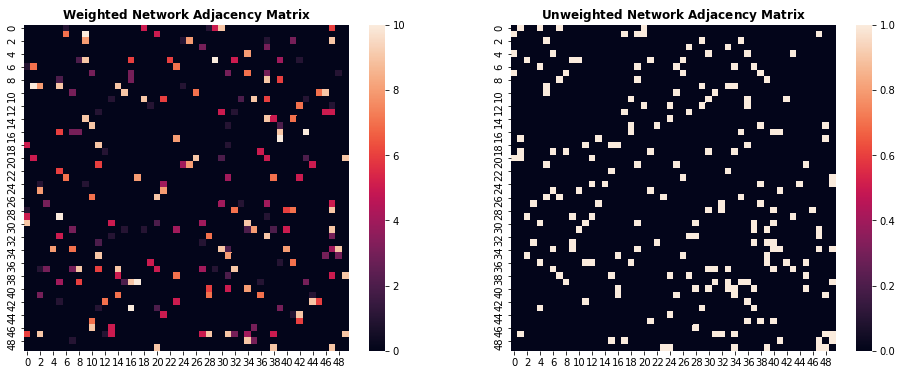

In [6]:
adj_ms = [nx.adjacency_matrix(G).todense() for G in sampled_networks]

fig_adj, axs_adj = plt.subplots(1, 2, figsize=(16,6))

axs_adj[1].title.set_text(r"$\mathbf{Unweighted\ Network\ Adjacency\ Matrix}$")
axs_adj[0].title.set_text(r"$\mathbf{Weighted\ Network\ Adjacency\ Matrix}$")

for i, adj_m in enumerate(adj_ms):
    sns.heatmap(adj_m, annot = False, ax = axs_adj[i])
    
plt.show()

We can see that both types of graphs have a uniform distribution of adjacency matrix. This is because the methods used to create graphs use uniform probability distributions (fixed probabilities).

# Part B: Analyzing Erdös-Renyi and Maslov-Sneppen graphs using centrality measures
## Defining Centrality Measures

In [7]:
## Defining a centrality list to use later
centralities = []

### 1. Closeness Centrality

In [8]:
def closeness_centrality(G):
    return nx.closeness_centrality(G, distance="weight")

centralities.append(closeness_centrality)

### 2. Node Degree Centrality

In [9]:
def degree_centrality(G):
    return dict(G.degree(weight = "weight"))

centralities.append(degree_centrality)

### 3. Communicability Centrality

In [10]:
## Some measures return centrality values for each pair of node.
## In that case we will take the sum of each node w.r.t. to their pairs, the authors used total communicability

def get_sum_by_node(node_dict):
    numbers = [node_dict[key] for key in node_dict]
    sum_result = sum(numbers)
    return sum_result

In [11]:
def communicability_centrality(G):
    raw_results = nx.communicability(G)
    for key in raw_results.keys():
        raw_results[key] = get_sum_by_node(raw_results[key])
        
    return raw_results

centralities.append(communicability_centrality)

### 4. Communicability Betweenness Centrality

In [12]:
def communicability_betweenness_centrality(G):
    return nx.communicability_betweenness_centrality(G)

centralities.append(communicability_betweenness_centrality)

### 5. Bridging Centrality

In [13]:
## This function is converted from the author's MATLAB code to python, manually
## Also used another theoretical source: https://www.centiserver.org/centrality/Bridging_Centrality/

def bridging_centrality(G):

    b = list(nx.betweenness_centrality(G).values())
    
    n = len(G.nodes())

    d = np.array([i[1] for i in G.degree()])

    if max(b) > 1:
        b = b / ((n - 1)*(n - 2))
    
    c = np.zeros(len(b))

    for k in range(n):
        neighbors = list(G.neighbors(k))
        deg_sum_of_nei = (1 / d[neighbors]).sum()
        c[k] = (1.0 / d[k]) / deg_sum_of_nei
        
    bc = np.array(b) * c
    return_dict = dict(zip(range(0, n), bc))
    
    return return_dict

centralities.append(bridging_centrality)

### 6. Eigenvector Centrality

In [14]:
def eigenvector_centrality(G):
    return nx.eigenvector_centrality(G, weight = "weight", max_iter = max_solver_iterations)

centralities.append(eigenvector_centrality)

### 7. PageRank Centrality

In [15]:
## Authors used alpha=0.85 in the paper

def pagerank_centrality(G):
    return nx.pagerank(G, alpha=0.85, weight = "weight", max_iter = max_solver_iterations)

centralities.append(pagerank_centrality)

### 8. H-Index

In [16]:
## This function is converted from the author's MATLAB code to python, manually

def get_h_index(G):
    
    nodes = G.nodes

    h_values = np.zeros(len(nodes))

    for node in nodes:
        
        try:      
            # Find the neighbours of node
            neighbors = list(G.neighbors(node))
            nei_count = len(neighbors)

            inner_h_values = np.zeros(nei_count)

            degrees = np.array([i[1] for i in G.degree(neighbors, weight = "weight")])

            # Loops over the neighbours of node i j times (where j is the number of
            # neighbours) and counts how many neighbours have at least j
            # degree/strength
            for nei_id, neighbor in enumerate(neighbors):
                inner_h_values[nei_id] = len(np.where(degrees >= nei_id+1)[0])

            # Finds the last point at which h of node i's neighbours do not have less than h degree/strength. 
            # This is the nodes' h-index
            h_values[node] = np.max(np.minimum(range(1, nei_count+1), inner_h_values))
            
        except: ## If the node don't have a neighbor, it'll give dimension error
            pass
        
    return_dict = dict(zip(range(0, len(nodes)), h_values))
    
    return return_dict

centralities.append(get_h_index)

### 9. Information Centrality

In [17]:
def information_centrality(G):
    return nx.information_centrality(G, weight = "weight", solver="full")

centralities.append(information_centrality)

### 10. Katz Centrality

In [18]:
def katz_centrality(G):
    
    ## The authors sets the alpha wrt to the largest eigenvalue of the adj matrix
    max_eigval = np.max(LA.eig(nx.adjacency_matrix(G, weight = "weight").todense())[0])
    
    return nx.katz_centrality(G, weight = "weight", max_iter = max_solver_iterations, alpha = 0.9 / max_eigval )

centralities.append(katz_centrality)

### 11. Laplacian Centrality

In [19]:
## Extra codes for weighted variant
## Source: https://andrewpwheeler.com/2015/07/29/laplacian-centrality-in-networkx-python/

def lap_energy(graph, weight='weight'):
    degrees = graph.degree(weight=weight)
    d1 = sum(v**2 for i,v in degrees.items())
    wl = 0
    for i in graph.edges(data=True):
        wl += (i[2].get(weight))**2
    return [d1,2*wl]

def cw(graph, node, weight='weight'):
    neis = graph.neighbors(node)
    ne = graph[node]
    cw,sub = 0,0
    for i in neis:
        we = ne[i].get(weight)
        od = graph.degree(i,weight=weight)
        sub += -od**2 + (od - we)**2
        cw += we**2
    return [cw,sub]

In [20]:
## Source: https://andrewpwheeler.com/2015/07/29/laplacian-centrality-in-networkx-python/

def laplacian_centrality(G, nbunch=None, norm=False):
    
    nodes = G.nodes
    
    weights = np.array([i for i in nx.get_edge_attributes(G, 'weight').values()])
    
    ## Check if the graph is weighted
    if len(np.where(weights != 1)[0]) > 0:
        weighted = True
    else:
        weighted = False
    
    ## If the graph is NOT WEIGHTED
    if not weighted:
        
        if nbunch is None:
            vs = G.nodes()
        else:
            vs = nbunch
            
        degrees = G.degree(weight=None)

        if norm is True:
            den = sum(v**2 + v for i,v in degrees.items())
            den = float(den)
        else:
            den = 1

        result = []

        for v in vs:
            neis = G.neighbors(v)
            loc = degrees[v]
            nei = 2*sum(degrees[i] for i in neis)
            val = (loc**2 + loc + nei)/den
            result.append(val)
            
    ## If the graph is weighted
    else:
        if nbunch is None:
            vs = G.nodes()
        else:
            vs = nbunch
            
        if norm == True:
            fe = lap_energy(G,weight="weight")
            den = float(fe[0]+fe[1])
        else:
            den = 1
            
        result = []
        
        for i in vs:
            d2 = G.degree(i, weight="weight")
            w2 = cw(G,i,weight="weight")
            fin = d2**2 - w2[1] + 2*w2[0]
            result.append(fin/den)   
            
    return_dict = dict(zip(range(0, len(nodes)), result))
    
    return return_dict

centralities.append(laplacian_centrality)

### 12. Leverage Centrality

In [21]:
def leverage_centrality(G):
    
    k = G.degree(weight = "weight")
    n = len(G.nodes())
    result = []
    
    for i in range(n):
        ki = k[i]
        if ki == 0:
            result.append(0.0)
        else:
            result.append(sum((ki-k[j])/(ki+k[j]) for j in G.neighbors(i)) / ki)
    
    return_dict = dict(zip(range(0, n), result))
    
    return return_dict

centralities.append(leverage_centrality)

### 13. Participation Coefficient Centrality

In [22]:
## Source: https://whitakerlab.github.io/scona/_modules/scona/graph_measures.html
## First, we get the best partition out of the graph

def calc_nodal_partition(G):

        
    # Make sure the edges are binarized
    for u, v, d in G.edges(data=True):
        if d.get('weight', 1) != 1:
            raise ValueError("G should be a binary graph")        
            
    # Now calculate the best partition
    nodal_partition = community.best_partition(G)

    # Reverse the dictionary to record a list of nodes per module, rather than
    # module per node
    module_partition = {}
    for n, m in nodal_partition.items():
        try:
            module_partition[m].append(n)
        except KeyError:
            module_partition[m] = [n]

    return nodal_partition, module_partition

In [23]:
## Source: https://whitakerlab.github.io/scona/_modules/scona/graph_measures.html
## Then, we run our measure on the best partition

def pc_centrality(G):

    ## Should run on degree mode, not strength
    copy_G = G.copy()
    for (u, v) in copy_G.edges():
        copy_G.edges[u,v]['weight'] = 1
        
    module_partition = calc_nodal_partition(copy_G)[1]
    
    # Initialise dictionary for the participation coefficients
    pc_dict = {}

    # Loop over modules to calculate participation coefficient for each node
    for m in module_partition.keys():
        # Create module subgraph
        M = set(module_partition[m])
        for v in M:
            # Calculate the degree of v in G
            degree = float(nx.degree(G=copy_G, nbunch=v))
            
            # Calculate the number of intramodule degree of v
            wm_degree = float(sum([1 for u in M if (u, v) in copy_G.edges()]))

            # The participation coeficient is 1 - the square of
            # the ratio of the within module degree and the total degree
            pc_dict[v] = (1 - ((float(wm_degree) / float(degree))**2)) if degree != 0 else 0

    pc_dict = dict(sorted(pc_dict.items()))
    return pc_dict

centralities.append(pc_centrality)

### 14. Subgraph Centrality 

In [24]:
def subgraph_centrality(G):
    return nx.subgraph_centrality(G)

centralities.append(subgraph_centrality)

### 15. Random-Walk Betweenness Centrality 

In [25]:
## Also known as current flow betweenness centrality
## Source: https://networkx.org/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.centrality.current_flow_betweenness_centrality.html

def random_walk_betweenness_centrality(G):
    return nx.current_flow_betweenness_centrality(G, weight = "weight")

centralities.append(random_walk_betweenness_centrality)

### 16. Random-Walk Closeness Centrality

In [26]:
## Also known as current flow closeness centrality

def random_walk_closeness_centrality(G):
    return nx.current_flow_closeness_centrality(G, weight = "weight")

centralities.append(random_walk_closeness_centrality)

### 17. Betweenness Centrality

In [27]:
def betweenness_centrality(G):
    return nx.betweenness_centrality(G, weight = "weight")

centralities.append(betweenness_centrality)

### Sanity Check

In [28]:
print("We got these centrality functions:", centralities, "\n")
print(len(centralities), "measures total. Like in the paper.")

We got these centrality functions: [<function closeness_centrality at 0x7f66b9caadd0>, <function degree_centrality at 0x7f67393fbd40>, <function communicability_centrality at 0x7f66b9c04b00>, <function communicability_betweenness_centrality at 0x7f66b9be00e0>, <function bridging_centrality at 0x7f66b9be07a0>, <function eigenvector_centrality at 0x7f66b9be0dd0>, <function pagerank_centrality at 0x7f66b9bdd440>, <function get_h_index at 0x7f66b9bddd40>, <function information_centrality at 0x7f66b9bd4320>, <function katz_centrality at 0x7f66b9bd49e0>, <function laplacian_centrality at 0x7f66b9bb3a70>, <function leverage_centrality at 0x7f66b9bdb170>, <function pc_centrality at 0x7f67393e7b90>, <function subgraph_centrality at 0x7f66b9bb3b00>, <function random_walk_betweenness_centrality at 0x7f66b9bb33b0>, <function random_walk_closeness_centrality at 0x7f66b9bd4e60>, <function betweenness_centrality at 0x7f66b9bd4050>] 

17 measures total. Like in the paper.


## Calculating CMCs

### Calculating Node Centralities for each Network
Calculating centralities of the nodes of Erdös-Renyi graphs...

In [29]:
erdos_centralities = np.zeros((graph_count, len(centralities), V))

for erdos_id, erdos in enumerate(tqdm(erdos_array)):
    for centrality_id, centrality in enumerate(centralities):
        erdos_centralities[erdos_id, centrality_id] = np.nan_to_num(np.array(list(centrality(erdos).values())), 0)

100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Calculating centralities of the nodes of Maslov-Sneppen graphs...

In [30]:
maslov_centralities = np.zeros((graph_count, len(centralities), V))

for maslov_id, maslov in enumerate(tqdm(maslov_array)):
    for centrality_id, centrality in enumerate(centralities):
        maslov_centralities[maslov_id, centrality_id] = np.nan_to_num(np.array(list(centrality(maslov).values())), 0)  

100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


### CMC Values
Calculating centrality measure correlations for each pair of measure and for each graph.

In [31]:
## Result arrays' shape: (graph_count, centrality_measure_count, node_count)

from itertools import permutations  

combinations = list(permutations(range(len(centralities)), 2)) ## creating all measure pair combinations

erdos_corr_dict_array = [] ## storess all cmcs for all erdös graphs
maslov_corr_dict_array = [] ## storess all cmcs for all maslov graphs

## FOR ERDOS GRAPHS 
print("Calculating CMCs for Erdös graphs...")
time.sleep(1)
for centrality_results in tqdm(erdos_centralities): ## for each graph
    
    corr_dict = {}
    
    for comb in combinations: ## for each pair of measure
        ## calculating spearman coefficient bw two measures by iterating on nodes
        coeff = stats.spearmanr(centrality_results[comb[0], :], centrality_results[comb[1], :], axis=None)
        corr_dict[comb] = coeff[0]
        
    erdos_corr_dict_array.append(corr_dict)
        
## FOR MASLOV GRAPHS 
print("Calculating CMCs for Maslov graphs...")
time.sleep(1)
for centrality_results in tqdm(maslov_centralities): ## for each graph
    
    corr_dict = {}
    
    for comb in combinations: ## for each pair of measure
        ## calculating spearman coefficient bw two measures by iterating on nodes
        coeff = stats.spearmanr(centrality_results[comb[0], :], centrality_results[comb[1], :], axis=None)
        corr_dict[comb] = coeff[0]
        
    maslov_corr_dict_array.append(corr_dict)

Calculating CMCs for Erdös graphs...


100%|██████████| 100/100 [00:10<00:00,  9.33it/s]


Calculating CMCs for Maslov graphs...


100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


### 1. Code up the necessary steps to reproduce plots A and B in Figure 2 using the Centrality Measure Correlation(CMC)s of the 40 networks you simulated: 20 weighted Erdos-Renyi and 20 unweighted Maslov-Sneppen networks.
Setting necessary functions and ordering the graphs by their median CMCs

In [32]:
## KDE Source: https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    kde = stats.gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid), kde

y_grid = np.linspace(-1, 1, 1000)
y_grid_scatter = np.linspace(-1, 1, 100)

## Ordering the graphs by their median CMC

erdos_medians = np.zeros(graph_count)

for erdos_i, erdos_corr_dict in enumerate(erdos_corr_dict_array):
    coeff_vals = np.array(list(erdos_corr_dict.values()))
    coeff_median = np.median(coeff_vals)    
    erdos_medians[erdos_i] = coeff_median
    
erdos_low_to_high = np.argsort(erdos_medians)
erdos_high_to_low_top_5 = erdos_low_to_high[::-1][[0,int(graph_count/4),int(graph_count/2),int(graph_count*3/4),-1]]

###

maslov_medians = np.zeros(graph_count)

for maslov_i, maslov_corr_dict in enumerate(maslov_corr_dict_array):
    coeff_vals = np.array(list(maslov_corr_dict.values()))
    coeff_median = np.median(coeff_vals)    
    maslov_medians[maslov_i] = coeff_median
    
maslov_low_to_high = np.argsort(maslov_medians)
maslov_high_to_low_top_5 = maslov_low_to_high[::-1][[0,int(graph_count/4),int(graph_count/2),int(graph_count*3/4),-1]]

print("To be plotted median CMCs for Erdös graphs:", erdos_medians[erdos_high_to_low_top_5])
print("To be plotted median CMCs for Maslov graphs:", maslov_medians[maslov_high_to_low_top_5])

To be plotted median CMCs for Erdös graphs: [0.87793517 0.80629052 0.76161347 0.7053981  0.36734036]
To be plotted median CMCs for Maslov graphs: [0.97944778 0.96917167 0.96033613 0.93562562 0.86318862]


Plotting. The authors plotting the scatter by sampling random points from the CMC distributions. They weren't actual CMC points. I am going to do the same, too.

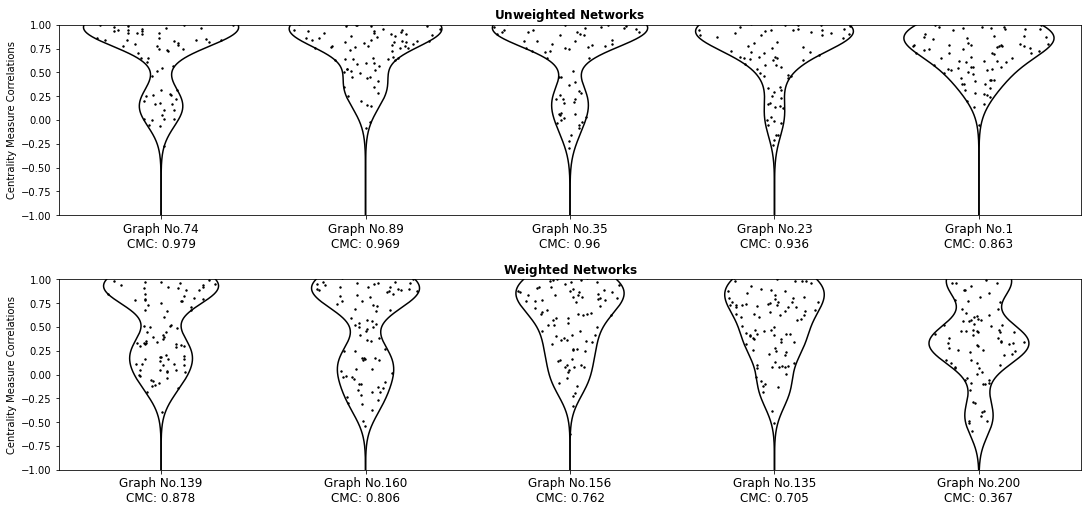

In [33]:
fig, axs = plt.subplots(2, figsize=(15, 7), constrained_layout=True)
axs[0].title.set_text(r"$\mathbf{Unweighted\ Networks}$")
axs[1].title.set_text(r"$\mathbf{Weighted\ Networks}$")

xticks = [0, 4, 8, 12, 16]

## PLOTTING MASLOV DISTRIBUTIONS
maslov_plotted_graphs_ids = []

for fori, i in enumerate(maslov_high_to_low_top_5):
    
    maslov_corr_dict = maslov_corr_dict_array[i]
    coeff_vals = np.array(list(maslov_corr_dict.values()))
    kde_val, kde_func = kde_scipy(coeff_vals, y_grid)
    interpolator = interp1d(y_grid, kde_val, kind='nearest', fill_value='extrapolate')
    
    axs[0].set_xlim([-2, 18])
    axs[0].set_ylim([-1, 1])
    axs[0].plot(kde_val + fori*4, y_grid, c="black")
    axs[0].plot(-kde_val + fori*4, y_grid, c="black")

    scatter_y_points = kde_func.resample(size=100).reshape(-1)
    max_xs = interpolator(scatter_y_points)
    random_xs = np.random.uniform(-max_xs, max_xs)
    
    cmc_value = np.around(maslov_medians[maslov_high_to_low_top_5][fori], 3)
    axs[0].scatter(random_xs + fori*4, scatter_y_points, s=2, color="black")
    maslov_plotted_graphs_ids.append("Graph No." + str(i+1) + "\nCMC: " + str(cmc_value))
    

axs[0].set_xticks(xticks)
axs[0].set_xticklabels(maslov_plotted_graphs_ids, rotation='horizontal', fontsize=12)
axs[0].set_ylabel("Centrality Measure Correlations")

## PLOTTING ERDÖS DISTRIBUTIONS

erdos_plotted_graphs_ids = []

for fori, i in enumerate(erdos_high_to_low_top_5):
    
    erdos_corr_dict = erdos_corr_dict_array[i]
    coeff_vals = np.array(list(erdos_corr_dict.values()))
    kde_val, kde_func = kde_scipy(coeff_vals, y_grid)
    interpolator = interp1d(y_grid, kde_val, kind='nearest', fill_value='extrapolate')
    
    axs[1].set_xlim([-2, 18])
    axs[1].set_ylim([-1, 1])
    axs[1].plot(kde_val + fori*4, y_grid, c="black")
    axs[1].plot(-kde_val + fori*4, y_grid, c="black")

    scatter_y_points = kde_func.resample(size=100).reshape(-1)
    max_xs = interpolator(scatter_y_points)
    random_xs = np.random.uniform(-max_xs, max_xs)
    
    cmc_value = np.around(erdos_medians[erdos_high_to_low_top_5][fori], 3)
    axs[1].scatter(random_xs + fori*4, scatter_y_points, s=2, color="black")
    erdos_plotted_graphs_ids.append("Graph No." + str(i+graph_count+1) + "\nCMC: " + str(cmc_value))
    

axs[1].set_xticks(xticks)
axs[1].set_xticklabels(erdos_plotted_graphs_ids, rotation='horizontal', fontsize=12)
axs[1].set_ylabel("Centrality Measure Correlations")

plt.show()


### 2. What conclusions can you derive from the plots?
In this graph, networks are ranked from the highest median correlation among themselves to the lowest. We can see that the lower the median correlation, the more homogenized the CMC distribution becomes. The plots drawn for networks represent "distribution functions" extracted from correlations of them. Also, we see that the CMC variance of weighted networks is higher. Centrality correlation values can give more unstable results in weighted networks. For a measure that cares about network weights, an unidentical weight values can greatly affect the value of the measurement. This may be the reason for the variance of the resultant CMCs in the weighted networks.

### 3. Code up the necessary steps to reproduce Figure 3 (A to D) using the between-network CMCs of the 40 networks you simulated: 20 weighted Erdos-Renyi and 20 unweighted Maslov-Sneppen networks.
Calculating the mean and std from the correlations

In [34]:
erdos_corr_matrix = np.zeros((graph_count, len(centralities), len(centralities)))
maslov_corr_matrix = np.zeros((graph_count, len(centralities), len(centralities)))

for g_id, erdos_corr_dict in enumerate(erdos_corr_dict_array):
    
    for i in range(len(centralities)): ## Filling up self correlations
        key_tuple = (i,i)
        erdos_corr_dict[key_tuple] = 1.
        
    erdos_corr_dict = dict(sorted(erdos_corr_dict.items()))
    erdos_corr_matrix[g_id] = np.array(list(erdos_corr_dict.values())).reshape(len(centralities), len(centralities))


for g_id, maslov_corr_dict in enumerate(maslov_corr_dict_array):

    for i in range(len(centralities)): ## Filling up self correlations
        key_tuple = (i,i)
        maslov_corr_dict[key_tuple] = 1.

    maslov_corr_dict = dict(sorted(maslov_corr_dict.items()))
    maslov_corr_matrix[g_id] = np.array(list(maslov_corr_dict.values())).reshape(len(centralities), len(centralities))


maslov_mean = maslov_corr_matrix.mean(axis=0)
maslov_std = maslov_corr_matrix.std(axis=0)
erdos_mean = erdos_corr_matrix.mean(axis=0)
erdos_std = erdos_corr_matrix.std(axis=0)

Plotting

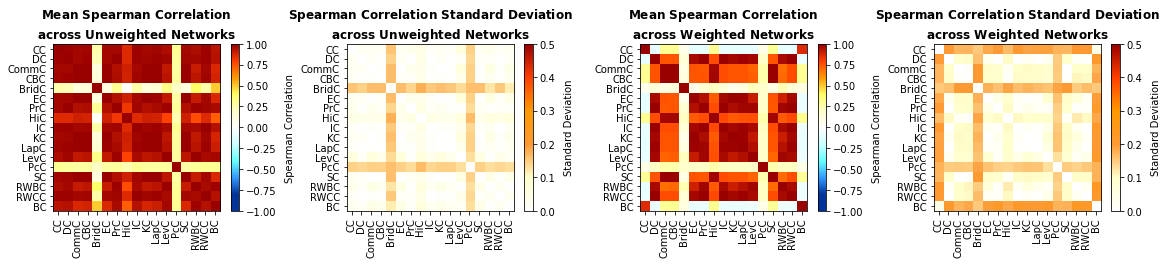

In [35]:
mean_colors = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#003399", "#003399", "#3399ff", "#66ffff", "#ccffff", "white", "#ffffcc", "#ffff66", "#ff9900", "#ff4000", "#990000"])
std_colors = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "#ffffcc", "#ff9933", "#ff9900", "#ff4000", "#990000"])

centrality_labels = ["CC", "DC", "CommC", "CBC", "BridC", "EC", "PrC", "HiC", "IC", "KC", "LapC", "LevC", "PcC", "SC", "RWBC", "RWCC", "BC"]
fig2, axs2 = plt.subplots(1, 4, figsize=(17,4))
caxs2 = [0,0,0,0]
plt.tight_layout(pad=5.0)

plot_iteration = [maslov_mean, maslov_std, erdos_mean, erdos_std]
cmap_iteration = [mean_colors, std_colors, mean_colors, std_colors]
cmap_ranges = [(-1, 1), (0, 0.5), (-1, 1), (0, 0.5)]
cb_labels = ["Spearman Correlation", "Standard Deviation", "Spearman Correlation", "Standard Deviation"]
titles = [r"$\mathbf{Mean\ Spearman\ Correlation}$"+"\n"+"$\mathbf{across\ Unweighted\ Networks}$",
          r"$\mathbf{Spearman\ Correlation\ Standard\ Deviation}$"+"\n"+"$\mathbf{across\ Unweighted\ Networks}$",
          r"$\mathbf{Mean\ Spearman\ Correlation}$"+"\n"+"$\mathbf{across\ Weighted\ Networks}$",
          r"$\mathbf{Spearman\ Correlation\ Standard\ Deviation}$"+"\n"+"$\mathbf{across\ Weighted\ Networks}$",
         ]

for plot_i, plot_data in enumerate(plot_iteration):
    axs2[plot_i].title.set_text(titles[plot_i])
    caxs2[plot_i] = axs2[plot_i].matshow(plot_data, cmap=cmap_iteration[plot_i], vmin=cmap_ranges[plot_i][0], vmax=cmap_ranges[plot_i][1])
    cb = fig.colorbar(caxs2[plot_i], ax=axs2[plot_i])
    axs2[plot_i].set_xticklabels(centrality_labels)
    axs2[plot_i].set_xticks(range(len(centrality_labels)))
    axs2[plot_i].set_yticklabels(centrality_labels)
    axs2[plot_i].set_yticks(range(len(centrality_labels)))
    cb.set_label(cb_labels[plot_i], labelpad=8)
    
    axs2[plot_i].tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    plt.setp([tick.label1 for tick in axs2[plot_i].xaxis.get_major_ticks()], rotation=90,
         ha="right", va="center", rotation_mode="anchor")
    


### 4. What conclusions can you derive from the plots?
On unweighted networks, all centralities except bridging centrality and participation coefficient centrality appear to be highly correlated. At the same time, the standard deviations of the correlations of these two measurements with the other measurements are higher than the remaining centrality pairs.

Participation Coefficient measures the strength of a node's connections within its community. On the other hand, bridging centrality considers the betweenness values of the nodes and the degree totals of their neighbors. I think the reason for the low correlation of these measurements is that for the relevant node, they only look at its "immediate neighbors".

In weighted networks, we can see that the correlation of betweenness and closeness measurements has decreased considerably. Because these measurements are being made according to the shortest paths. And now these distances are calculated not according to hop count, but according to total edge weights. We also see a lower overall correlation values in weighted networks. The weighted structure of the networks generally reduces the measure correlation.

### 5. Plot the CMC distributions using bar plots as in the Figure 4 for your 20 unweighted and 20 weighted networks. What do you notice?

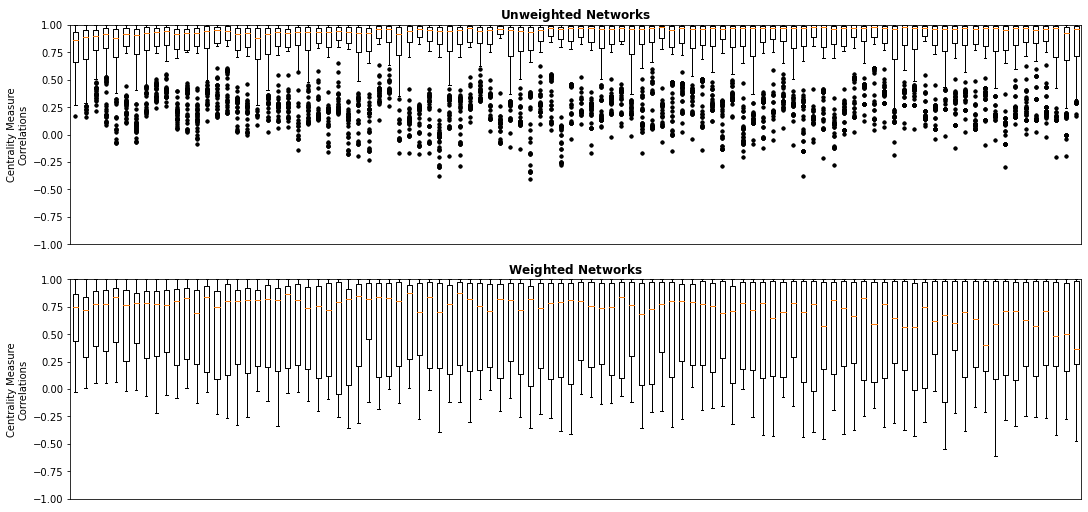

In [36]:
matplotlib.rcParams.update({'errorbar.capsize': 5})

fig3, axs3 = plt.subplots(2, figsize=(15, 7), constrained_layout=True)
axs3[0].title.set_text(r"$\mathbf{Unweighted\ Networks}$")
axs3[1].title.set_text(r"$\mathbf{Weighted\ Networks}$")

## FOR WEIGHTED

corrs = [maslov_corr_dict_array, erdos_corr_dict_array]

for corr_i, corr_dict_array in enumerate(corrs):
    
    cmc_values_set = []
    
    for i, corr_dict in enumerate(corr_dict_array):
        
        cmc_values = np.array(list(corr_dict.values()))
        cmc_values = cmc_values[cmc_values != 1] ## excluding self correlations (ones)  
        cmc_values_set.append(cmc_values)
    
    axs3[corr_i].boxplot(cmc_values_set, 0, 'k.') 
    axs3[corr_i].set_xticks([])
    axs3[corr_i].set_ylim([-1, 1])
    axs3[corr_i].set_ylabel("Centrality Measure\nCorrelations")

As we can see in the heatmap figure and this figure, we can notice that variance is wider and mean is lower for CMCs in weighted networks. If weights are used in the structure of a network, the average correlation between centrality measurements weakens.

At the same time, the average correlation is higher in unweighted networks, while also the number of outliers (0.35 percentile) is higher.

# Part C: Association between mean within-network Centrality Measure Correlation(CMC) and network properties

### 1. Choose two different network properties (e.g., modularity and density) and regenerate similar plots to Figure 5 by plotting the mean within-network CMC against the selected network property. Erdos-Renyi networks should have the same color (e.g., transparent blue) and Maslov-Sneppen networks can be assigned a different color (e.g., transparent red). You can use existing codes to compute the network properties.

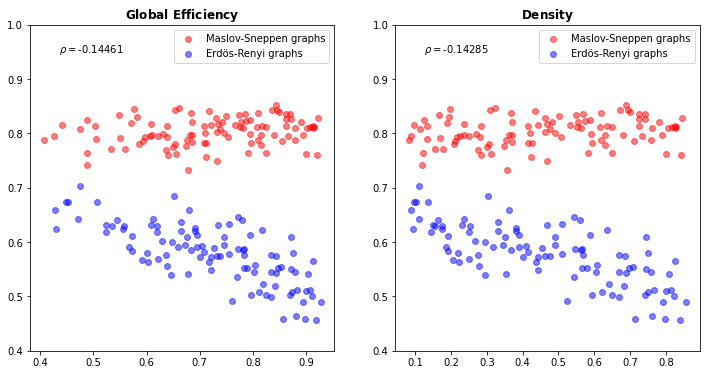

In [37]:
fig4, axs4 = plt.subplots(1, 2, figsize=(12,6))
axs4[0].title.set_text(r"$\mathbf{Global\ Efficiency}$")
axs4[1].title.set_text(r"$\mathbf{Density}$")

corrs = [maslov_corr_dict_array, erdos_corr_dict_array]
total_graphs = [maslov_array, erdos_array]

graph_functions = [nx.global_efficiency, nx.density]
graph_function_lims = [(0,1), (0,1)]
colors = ["red", "blue"]
labels = ["Maslov-Sneppen graphs", "Erdös-Renyi graphs"]


## To prevent duplicate legend labels
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
for func_i in range(2):
    
    x_n_ys = np.zeros((graph_count*2, 2))
    
    for corr_i, corr_dict_array in enumerate(corrs):
        for i, corr_dict in enumerate(corr_dict_array):
            cmc_values = np.array(list(corr_dict.values()))

            func_output = graph_functions[func_i](total_graphs[corr_i][i])
                
            mean_in_network = cmc_values.mean()
            axs4[func_i].scatter([func_output], [mean_in_network], s=35, c=colors[corr_i], alpha=0.5, label=labels[corr_i])
            x_n_ys[graph_count*corr_i+i] = np.array([func_output, mean_in_network])
    
    graph_coeff = stats.pearsonr(x_n_ys[:, 0], x_n_ys[:,1])
    axs4[func_i].text(0.20, 0.915, r'$\rho=$' + str(np.round(graph_coeff[0], 5)), horizontalalignment='center', transform=axs4[func_i].transAxes)
    axs4[func_i].set_ylim([0.4, 1])
    axs4[func_i].legend()
    legend_without_duplicate_labels(axs4[func_i])

### 2. Interpret your plots. What conclusions can you derive?

Global efficiency indicates the multiplicative inverse of the shortest path distance between the nodes.
Density indicates the number of edges per node pair. While global efficiency takes into account the shortest routes, the density measure takes into account inferential node degrees.

Maslov graphs show a clear superiority in correlation with both selected criteria. Although the figures show reaction to only two characteristics, the reactions to other characteristics are quite similar. It turns out that "weighted" network type is one of the biggest factors reducing correlation between centrality measures. Thus, these two graph structures (Erdös-Renyi and Maslov-Sneppen) can be easily separated from each other.

At the same time, a decreasing trend was observed in correlation values as both scales increased in Erdös-Renyi graphs. In weighted graphs, we can say that increasing the number of links and performing shortest path optimization decreases the correlation. I see the reason for this that some centrality measures are not fully adapted to the weighted networks.

Both network types have given the same responses for these two characteristics. From this, we can argue that the changes in density and global efficiency produce correlated results. It can be thought that as the number of edges per node increases, the possibility of optimizing the shortest path also increases.